# OpenShift Image Layer Monitoring

## Background
When using the [OKD 3.11 Image Streams] or the [OCP 3.11 Image Streams] as a [container image registry], care must be taken to avoid exhausting the available storage on the host nodes when the registry has been configured with the [filesystem driver] backed by a [glusterfs volume].

The [Open Container Initiative Distribution Specification], maintained by the [Linux Foundation Open Container Intitiative] governs container image registry mechanics. The mechanic of a `tag` as defined in this distribution specification enables one-line launch of an OCI container across compatible runtimes.

For example, the `latest` tag of the `registry.fedoraproject.org/fedora` image can be launched by both [podman] and [docker] using:

```bash
$ podman run registry.fedoraproject.org/fedora:latest
$ docker run registry.fedoraproject.org/fedora:latest
```

### Implementation of a Tag
In order to make sense of how these tags are consumed, the [skopeo] utility is used.

```bash
$ skopeo inspect docker://registry.fedoraproject.org/fedora:latest
{
    "Name": "registry.fedoraproject.org/fedora",
    "Digest": "sha256:655721ff613ee766a4126cb5e0d5ae81598e1b0c3bcf7017c36c4d72cb092fe9",
    "RepoTags": [
        "24",
        "25",
        "26-modular",
    ...
    ],
    "Created": "2020-04-29T06:48:16Z",
    "DockerVersion": "1.10.1",
    "Labels": {
        "license": "MIT",
        "name": "fedora",
        "vendor": "Fedora Project",
        "version": "32"
    },
    "Architecture": "amd64",
    "Os": "linux",
    "Layers": [
        "sha256:3088721d7dbf674fc0be64cd3cf00c25aab921cacf35fa0e7b1578500a3e1653"
    ],
    "Env": [
        "DISTTAG=f32container",
        "FGC=f32",
        "container=oci"
    ]
}
```

We can see that the `latest` tag references an image that has a digest of `sha256:655721ff613ee766a4126cb5e0d5ae81598e1b0c3bcf7017c36c4d72cb092fe9` and when podman attempts to run that image by that digest it will need to fetch the layer of `sha256:3088721d7dbf674fc0be64cd3cf00c25aab921cacf35fa0e7b1578500a3e1653`. Since fetching images and their layers are expensive operations, the `sha256` digest and layers are used as immutable identifiers: if a tag points to a digest that has already been fetched before, or the digest points to a layer that has already been fetched before then the layer or digest already present locally is reused. This mechanism is known as [content-addressing].

### Implementation of a Digest

Since Docker v1.10 images and layers [have been implemented] in the form of a content-addressible id of the form `algorithm:hex`. Images are now identifiable by digest, and image tags are effectively pointers to an image digest. This became part of the [OCI Image Format Specification].

### Implementation of a Layer
The [`dive`](https://github.com/wagoodman/dive) tool can be used to explore the layers in an image. Like images themselves, layers are content-addressed so any two identical layers are [reified] regardless of their provenance and end up stored exactly once on disk.
![dive demo](https://raw.githubusercontent.com/wagoodman/dive/103b05f3c083c857f6fd4c3b3b3e22ace5577d53/.data/demo.gif)

### Divergence
In OpenShift Red Hat has implemented image stream tags as a stack of digests rather than as a single pointer to a single digest. This means that when an image stream tag is fetched, the latest digest is always returned: each image stream tag always points to the latest digest. However, when a new image is pushed to an existing tag the existing image digest isn't immediately deleted but is pushed down the stack. This is an excellent design in theory: by referencing image digests directly in deployment configs and other deployable artefacts rather than image stream tags, new versions of an image can be rolled out smoothly without breaking references to the existing deployed image with that tag. Theoretically the depth of the stack (the history) is tunable by an operations team based on available space without requiring an application team to manually manage garbage collection of old images. The number of historical images kept by an imagestream is intended to be controlled by the [OCP 3.11 pruner] configuration.

The complete list of digests can be found using the image stream tag using the OpenShift API, enabling exploration of the working mechanics of image stream tags as deployed on a live cluster.

Unfortunately, the team observed that the registry had not been cleaning up historical digests on these mutable tags with multiple image digests in their history. Colloquially these tags with multiple image digest references are known as "tracking tags" and image tags with exactly one reference are known as "release tags" or "pinning tags". One reason old images (digests) were not cleaned up was because multiple tags included the same image digest in their history. The cleanup issue did not appear to be purely limited to tracking tags with pinning tags referencing old images, and due to rapid response to clear the registry an isolated case for reproduction was not created. Further work is needed.


### TL;DR
OCI Distribution Spec:
- `tag` has one `digest` has many `layers`.

Red Hat Image Stream:
- `tag` has many `digests` has many `layers`.

[reified]: http://web.archive.org/web/20200609165730/https://en.wikipedia.org/wiki/Reification_(computer_science)
[OCI Image Format Specification]: https://github.com/opencontainers/image-spec/blob/db4d6de99a2adf83a672147d5f05a2e039e68ab6/spec.md
[have been implemented]: http://web.archive.org/web/20200609165422/https://windsock.io/explaining-docker-image-ids/
[content-addressing]: http://web.archive.org/web/20200609165250/https://flyingzumwalt.gitbooks.io/decentralized-web-primer/avenues-for-access/lessons/power-of-content-addressing.html
[glusterfs volume]: http://web.archive.org/web/20200609164942/https://docs.openshift.com/container-platform/3.11/install_config/persistent_storage/persistent_storage_glusterfs.html
[filesystem driver]: http://web.archive.org/web/20200608231733/https://docs.openshift.com/container-platform/3.11/install_config/registry/extended_registry_configuration.html#docker-registry-configuration-reference-storage
[OCP 3.11 pruner]: https://docs.openshift.com/container-platform/3.11/admin_guide/pruning_resources.html
[skopeo]: https://github.com/containers/skopeo/blob/release-0.1.40-rhel/docs/skopeo.1.md
[podman]: http://web.archive.org/web/20200607194203/http://docs.podman.io/en/latest/
[docker]: http://web.archive.org/web/20200607194017/https://docs.docker.com/get-started/overview/
[Linux Foundation Open Container Intitiative]: http://web.archive.org/web/20200607192612/https://opencontainers.org/about/overview/
[Open Container Initiative Distribution Specification]: https://github.com/opencontainers/distribution-spec/blob/6a6ee23bbab1e5d07b45a10547265bc5249c3c4d/spec.md
[container image registry]: http://web.archive.org/web/20200608231542/https://docs.openshift.com/container-platform/3.11/install_config/registry/
[OKD 3.11 Image Streams]: http://web.archive.org/web/20200607190740/https://docs.okd.io/3.11/architecture/core_concepts/builds_and_image_streams.html#image-streams
[OCP 3.11 Image Streams]: https://web.archive.org/web/20200607190127/https://docs.openshift.com/container-platform/3.11/architecture/core_concepts/builds_and_image_streams.html#image-streams

## Running This Notebook

Given this notebook requires an authenticated connection to Pathfinder, it is inadvisable to follow these steps on a https://mybinder.org/ instance of this notebook. Use of a locally-installed JupyterLab instance is recommended. The `make install` target can be used to build a suitable local instance.

1. visit the [pathfinder console](https://console.pathfinder.gov.bc.ca:8443/console/projects)
2. select your username from top right corner of the dashboard
3. click `Copy Login Command`
4. open a terminal and run the command (File -> New -> Terminal)
5. if `oc whoami` prints out your github username you've done this right
6. (optional) edit the default openshift namespace in the setup block below

In [1]:
import numpy as np
import pandas as pd
from kubernetes import client, config
from openshift.dynamic import DynamicClient
import plotly.express as px
from tqdm.notebook import tqdm
import os
from functools import reduce
import humanize

namespace = os.environ.get('OPENSHIFT_NAMESPACE', 'wksv3k-tools')

k8s_client = config.new_client_from_config()
dyn_client = DynamicClient(k8s_client)

The first stage fetches all the [Image Streams](http://web.archive.org/web/20200608234852/https://docs.openshift.com/container-platform/3.11/architecture/core_concepts/builds_and_image_streams.html#image-streams) in the namespace. This attempt will error if the client isn't authenticated with openshift. The `oc login` command copied from the OpenShift GUI into the Jupyter Terminal writes an authentication token to `~/.kube/config`, which `kubernetes.client` automatically discovers and uses.

More detail can be found in the officical api docs for [v1.ImageStream](http://web.archive.org/web/20200529162217/https://docs.openshift.com/container-platform/3.11/rest_api/apis-image.openshift.io/v1.ImageStream.html)

In [2]:
v1_image_streams = dyn_client.resources.get(api_version='image.openshift.io/v1', kind='ImageStream')

with tqdm(total=1) as pbar:
    image_streams_list = v1_image_streams.get(namespace=namespace)
    pbar.update(1)

Next, we process the list of tags for each imagestream in the namespace to identify all the image digests attached to those image streams. The digests are loaded into a dict that maps the digest to an image stream digest tag that will be used to fetch details on this image.

The variables set by the prior block are cached for re-use in subsequent self-contained blocks.

In [3]:
image_stream_image_names = dict()

for image_stream in image_streams_list.items:
    if image_stream.status.tags:
        for tag in image_stream.status.tags:
            if tag.items:
                for item in tag.items:
                    image_stream_image_name = '{}@{}'.format(image_stream.metadata.name, item.image)
                    image_stream_image_names[item.image] = image_stream_image_name

image_stream_count = len(image_streams_list.items)
image_stream_tag_count = len(image_stream_image_names)

print('{} image digests in {} image streams'.format(image_stream_tag_count, image_stream_count))

526 image digests in 32 image streams


A digest loooks like `sha256:de78803598bc4c940fc4591d412bffe488205d5d953f94751c6308deeaaa7eb8` and a digest tag that can be fetched using the `image.openshift.io/v1.ImageStreamImage` api is prefixed with the image stream that contains it so that looks like `alpine@sha256:de78803598bc4c940fc4591d412bffe488205d5d953f94751c6308deeaaa7eb8`. 

More detail can be found in the official api docs for [v1.ImageStreamImage](http://web.archive.org/web/20200608234324/https://docs.openshift.com/container-platform/3.11/rest_api/apis-image.openshift.io/v1.ImageStreamImage.html).

This next stage may take a few minutes. If the `tqdm` extension isn't rendering a progress bar, be patient.

In [4]:
image_stream_images = dict()
v1_image_stream_images = dyn_client.resources.get(api_version='image.openshift.io/v1', kind='ImageStreamImage')

with tqdm(total=image_stream_tag_count) as pbar:
    for digest, name in image_stream_image_names.items():
        image_stream_image = v1_image_stream_images.get(name=name, namespace=namespace)
        image_stream_images[digest] = image_stream_image
        pbar.update(1)

Now we have a complete data set, we can prepare a dataframe for graphing using pandas. We calculate the virtual size of all image layers as well as count the number of times that they are reused in our namespace. The reuse count enables us to accurately represent the attributable portion of storage, the "actual bits" consumed by each layer in the context of an image digest.

More information is available in the official intro docs to pandas [DataFrame](http://web.archive.org/web/20200608235412/https://pandas.pydata.org/pandas-docs/stable/getting_started/dsintro.html#dataframe)

In [5]:
columns=list(['namespace', 'project', 'tag', 'digest', 'layer', 'virtual_bits', 'actual_bits', 'reused_count'])

rows = []
reuse_count = dict()
for image_stream in image_streams_list.items:
    if image_stream.status.tags:
        for tag in image_stream.status.tags:
            if tag.items:
                for item in tag.items:
                    image = image_stream_images[item.image]
                    for layer in image.image.dockerImageLayers:
                        reuse_count[layer.name] = 1 + reuse_count.get(layer.name, 0)
                        rows.append([
                            image_stream.metadata.namespace, 
                            image_stream.metadata.name, 
                            tag.tag, 
                            image.image.metadata.name,
                            layer.name,
                            layer.size,
                            0,
                            0])

# we need the `reuse_count` dict in order to calculate actual bits via the reused count
for row in rows:
    row[7] = reuse_count[row[4]] # fetch the calculated reused_count using the layer.name
    row[6] = row[5] / row[7] # allocate the correct fraction of layer size to this layer
df = pd.DataFrame(rows, columns=columns)

virtual_usage = humanize.naturalsize(df['virtual_bits'].sum())
actual_usage = humanize.naturalsize(df['actual_bits'].sum())

We start by charting the Virtual Usage of our containers. This is how much space it would take to store our layers without a checksum-driven content-addressing scheme. Another way to think about it is this is how much space our layers would be taking up if each tag of each image were stored independently and not in a consolidated registry.

In an attempt not to overwhelm the browser we avoid rendering all the way down to the layer level by default and stop at the digest. If insight into granular layer usage is desired the path argument can be adjusted.

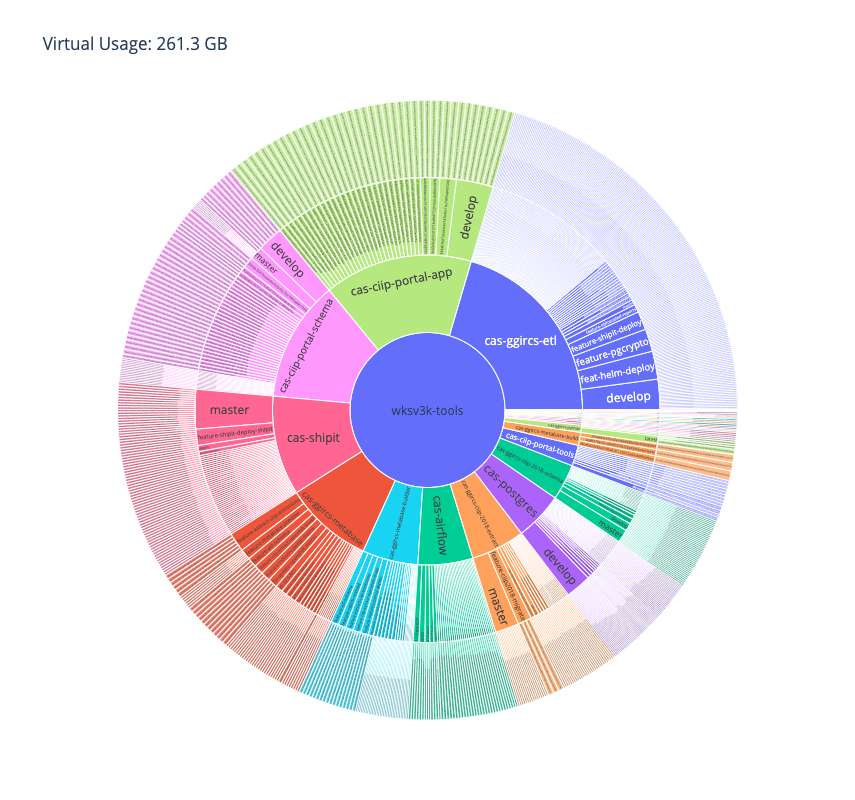

In [6]:
path = ['namespace', 'project', 'tag', 'digest']
# path = ['namespace', 'project', 'tag', 'digest', 'layer']
size = 800
fig = px.sunburst(
    df,
    title='Virtual Usage: {}'.format(virtual_usage),
    path=path,
    values='virtual_bits', 
    color='project',
    width=size,
    height=size)
fig.show()

We then chart the actual usage of each layer. Note that the more times a layer is reused the lower its actual usage per image digest. Using more tags doesn't produce any additional impact when they map to the same image digests, but it can prevent the image digests being removed from the image stream by the pruner. This means that there's actually some value in *larger* base images if a larger base image enables better layer re-use. However a larger image takes longer to download and unpack, and is more expensive to store, so we always want to balance layer size against the layer reuse ratio.

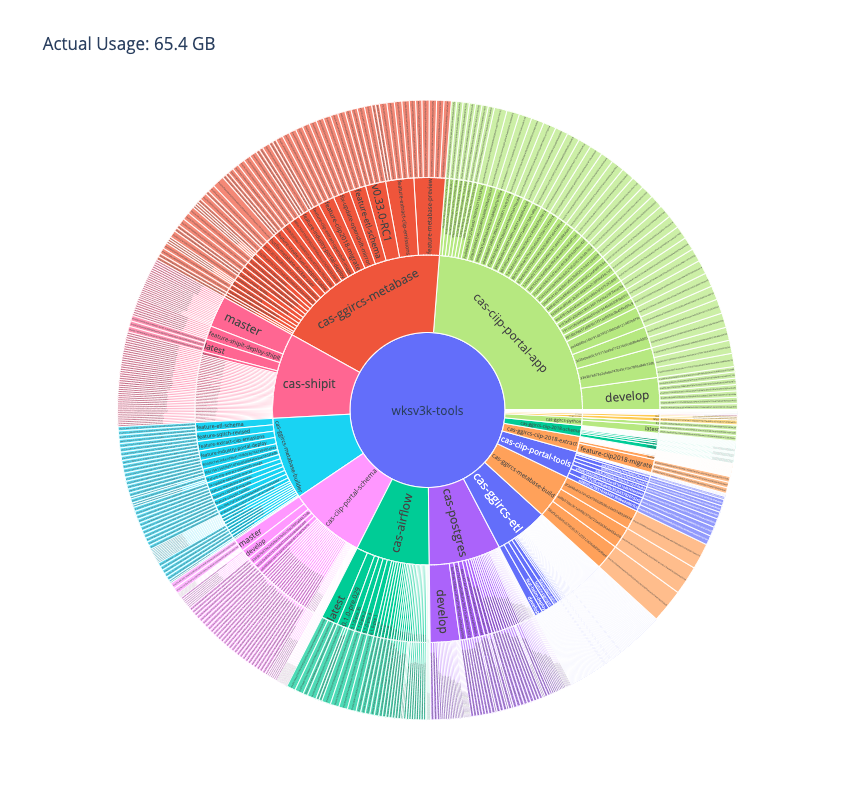

In [7]:
fig = px.sunburst(
    df,
    title='Actual Usage: {}'.format(actual_usage),
    path=path,
    values='actual_bits', 
    color='project',
    width=size,
    height=size)
fig.show()

If the virtual and actual usage are significantly different, it can be helpful to drill down to identify large low-reuse layers.

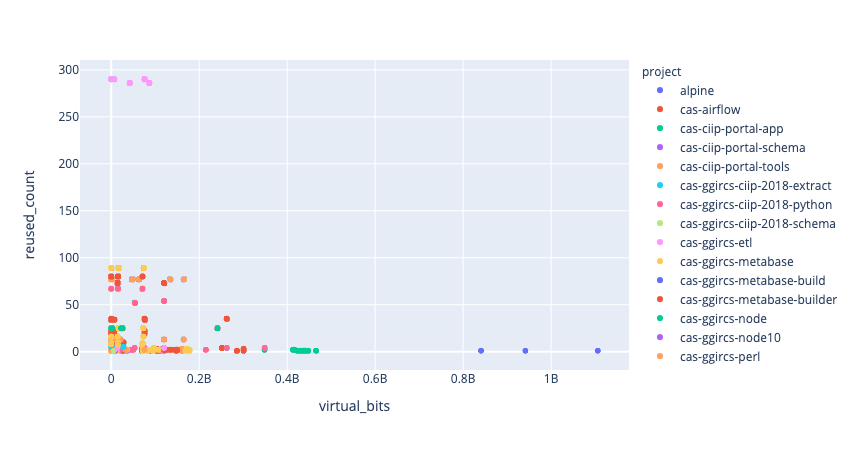

In [8]:
fig = px.scatter(
    df,
    x='virtual_bits', 
    y='reused_count', 
    color='project', 
    hover_data=['layer', 'tag', 'project'],
    labels={'bits': 'Size of layer in bits', 'count': 'Number of times layer is reused'})
fig.show()